In [77]:
!pip install add_gradient_checkpointing

ERROR: Could not find a version that satisfies the requirement add_gradient_checkpointing (from versions: none)
ERROR: No matching distribution found for add_gradient_checkpointing


In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, BatchNormalization, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


train_dataset_path = '/content/drive/MyDrive/Depression_clean/Train/'
test_dataset_path = '/content/drive/MyDrive//Depression_clean/Test/'

# Constants
input_shape = (440, 440, 3)
num_classes = len(os.listdir(train_dataset_path))

# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical'
)

batch_size = 1

# Define your RNN model
input_layer = Input(shape=(input_shape[0], input_shape[1] * input_shape[2]))  # Flatten the image
x = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(input_layer)  # Reshape to (timesteps, features)
x = LSTM(256, return_sequences=True)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Dataset/rnn_best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=50,
    validation_data=test_generator,
    callbacks=[checkpoint]
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 149 images belonging to 5 classes.
Found 39 images belonging to 5 classes.
Epoch 1/50
149/149 [==============================] - ETA: 0s - loss: 1.6074 - accuracy: 0.4497
Epoch 1: val_accuracy improved from -inf to 0.20513, saving model to /content/drive/MyDrive/Dataset/rnn_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 36s 222ms/step - loss: 1.6074 - accuracy: 0.4497 - val_loss: 1.6256 - val_accuracy: 0.2051
Epoch 2/50
149/149 [==============================] - ETA: 0s - loss: 1.6034 - accuracy: 0.4564
Epoch 2: val_accuracy improved from 0.20513 to 0.23077, saving model to /content/drive/MyDrive/Dataset/rnn_best_model.h5
149/149 [==============================] - 14s 95ms/step - loss: 1.6034 - accuracy: 0.4564 - val_loss: 1.6405 - val_accuracy: 0.2308
Epoch 3/50
149/149 [==============================] - ETA: 0s - loss: 1.5996 - accuracy: 0.4564
Epoch 3: val_accuracy improved from 0.23077 to 0.25641, saving model to /content/drive/MyDrive/Dataset/rnn_best_model.h5
149/149 [==============================] - 14s 97ms/step - loss: 1.5996 - accuracy: 0.4564 - val_loss: 1.7740 - val_accuracy: 0.2564
Epoch 4/50
149/149 [==============================] - ETA: 0s - loss: 1.5958 - accuracy: 0.4564
Epoch 4: val_accuracy did not improve from 0.25641
149/149 [==========

39/39 [==============================] - 1s 16ms/step - loss: 3.2166 - accuracy: 0.3077
Test Loss: 3.2166
Test Accuracy: 0.3077
39/39 [==============================] - 1s 20ms/step
                              precision    recall  f1-score   support

             Mild Depression       0.33      0.10      0.15        10
          Minimal Depression       0.38      0.29      0.33        17
         Moderate Depression       0.07      0.17      0.10         6
Moderately Severe Depression       0.17      0.25      0.20         4
            Severe Depressed       0.00      0.00      0.00         2

                    accuracy                           0.21        39
                   macro avg       0.19      0.16      0.16        39
                weighted avg       0.28      0.21      0.22        39



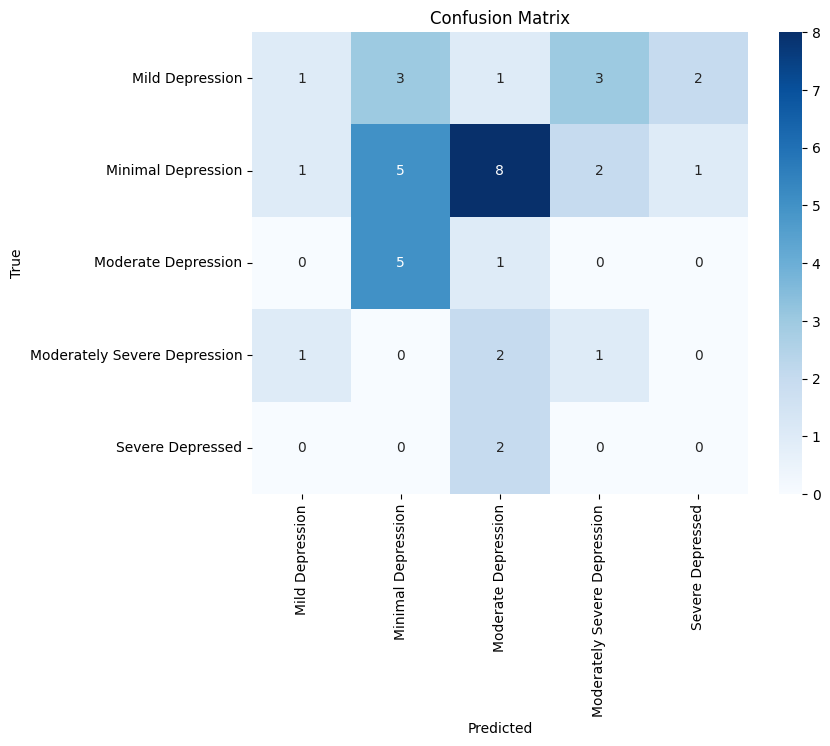

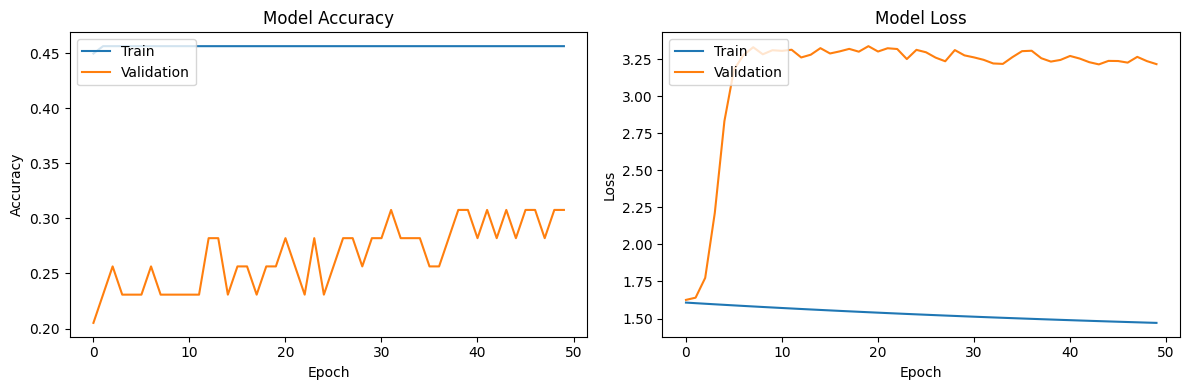

In [79]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report and confusion matrix
test_labels = test_generator.classes
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

# Classification Report
print(classification_report(test_labels, test_pred_labels, target_names=class_labels))

# Confusion Matrix
confusion_mat = confusion_matrix(test_labels, test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


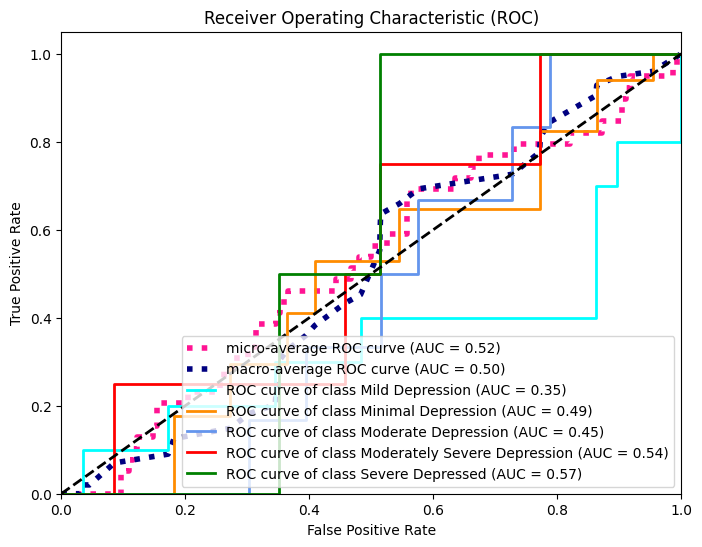

In [80]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# ... (previous code)

# One-hot encode class labels
lb = LabelBinarizer()
test_labels = lb.fit_transform(test_generator.classes)

# Calculate ROC curves and AUC values for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), test_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


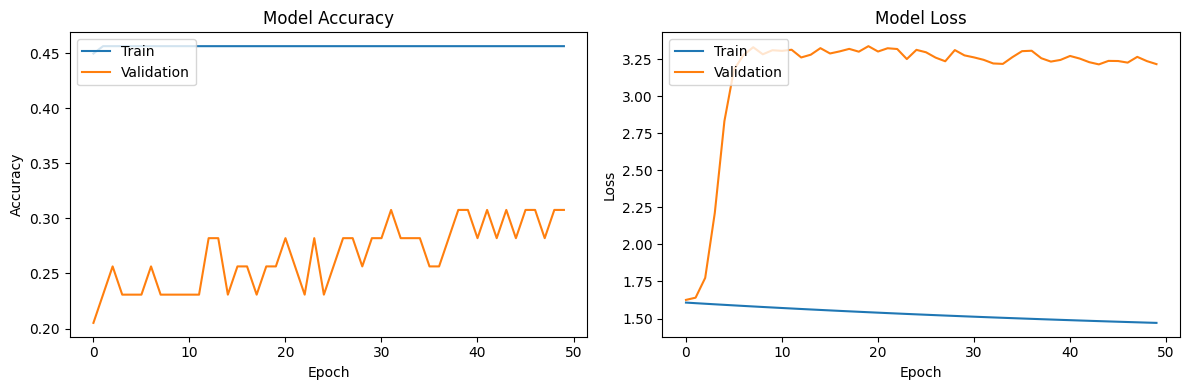

In [81]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


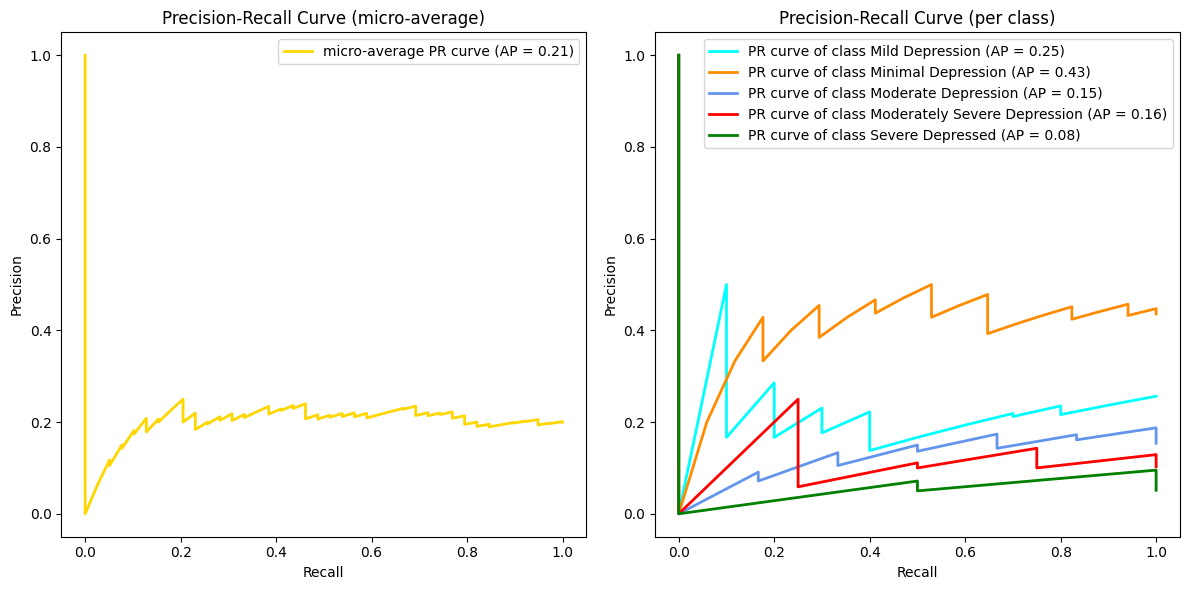

In [83]:
from sklearn.metrics import precision_recall_curve, average_precision_score, cohen_kappa_score
# Calculate precision-recall curves and average precision (AP) for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], test_predictions[:, i])
    average_precision[i] = average_precision_score(test_labels[:, i], test_predictions[:, i])

# Compute micro-average precision-recall curve and AP
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels.ravel(), test_predictions.ravel())
average_precision["micro"] = average_precision_score(test_labels, test_predictions, average="micro")

# Calculate Cohen's Kappa
cohen_kappa = cohen_kappa_score(np.argmax(test_labels, axis=1), np.argmax(test_predictions, axis=1))


# Plot precision-recall curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(recall["micro"], precision["micro"], color='gold', lw=2,
         label=f'micro-average PR curve (AP = {average_precision["micro"]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (micro-average)')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PR curve of class {class_labels[i]} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (per class)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
